# An Introduction to BERT

[Lecture video](https://youtu.be/odYvCxMBrl4)

### Installation

Install transformers for BERT and praw for Reddit data collection

In [ ]:
!pip install transformers
!pip install praw

In [ ]:
from transformers import TFAutoModelForTokenClassification, AutoTokenizer #Tokenizer and the BERT model
from matplotlib import pyplot as plt #Matplotlib for plotting the results
import tensorflow as tf #Tensorflow for DL
import praw #Reddit API for imports
import pandas as pd #Pandas for data structures

In [ ]:
model = TFAutoModelForTokenClassification.from_pretrained("dbmdz/bert-large-cased-finetuned-conll03-english") #This right here is the BERT pretrained model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") #This is the tokenizer that we will be using to tokenize the strings before sending them to the NN

In [ ]:
label_list = [
    "O",       # Outside of a named entity
    "B-MISC",  # Beginning of a miscellaneous entity right after another miscellaneous entity
    "I-MISC",  # Miscellaneous entity
    "B-PER",   # Beginning of a person's name right after another person's name
    "I-PER",   # Person's name
    "B-ORG",   # Beginning of an organisation right after another organisation
    "I-ORG",   # Organisation
    "B-LOC",   # Beginning of a location right after another location
    "I-LOC"    # Location
]

### Using the Reddit API

[Click here to create a Reddit app instance](https://ssl.reddit.com/prefs/apps)

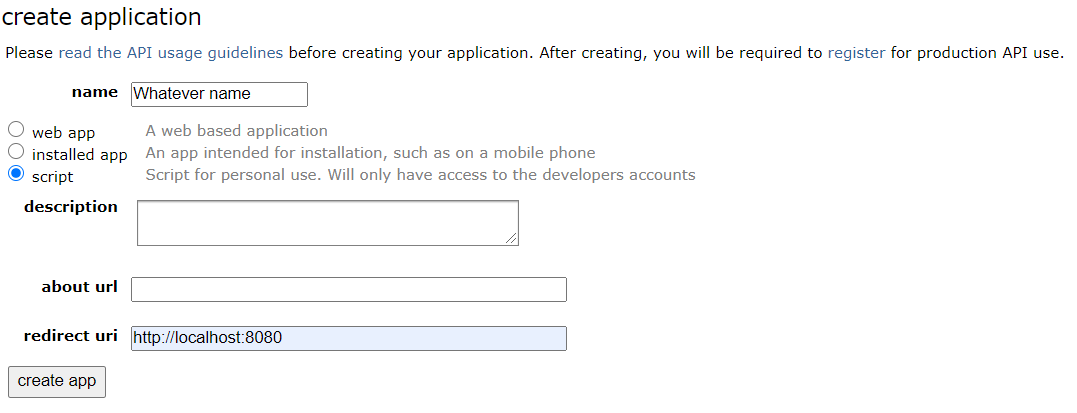

### Fill the details and click on create app


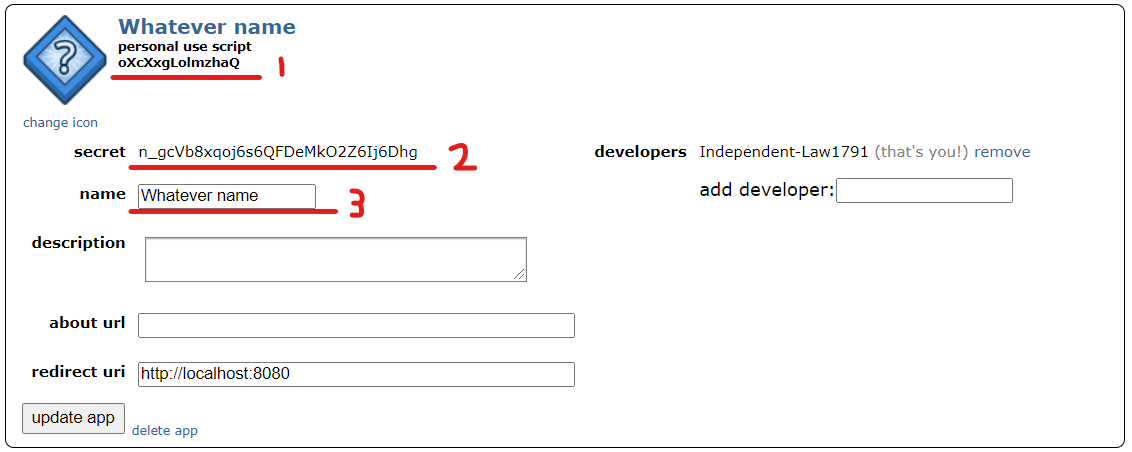

In [ ]:
reddit = praw.Reddit(client_id='Your 1 goes here', 
                     client_secret='2 goes here',
                     user_agent='Name goes here')

In [ ]:
def replies_of(top_level_comment, comment_list):
    if len(top_level_comment.replies) == 0:
        return
    else:
        for num, comment in enumerate(top_level_comment.replies):
            try:
                comment_list.append(str(comment.body))
            except:
                continue
            replies_of(comment, comment_list)

In [ ]:
count = 0
master_dict = {'I-LOC': [], 'I-ORG': [], 'I-PER': [], 'B-LOC': [], 'B-ORG': [], 'B-PER': []} #BERT recognised tags for its pre trained vocabulary
word_temp = ''
current_tag = ''
old_tag = ''
print_dict = {}

### Enter your subreddit of choice below


In [ ]:
list_of_subreddit = ['Enter valid subreddit title here. It is case sensitive']

In [ ]:
for j in list_of_subreddit:
    top_posts = reddit.subreddit(j).top('month', limit=1)
    comment_list = [] #Your fetched data goes here
    # save subreddit comments in dataframe
    for submission in top_posts:
        submission_comm = reddit.submission(id=submission.id)
        comment_list.append(str(submission.title))

        for count, top_level_comment in enumerate(submission_comm.comments):
            try:
                replies_of(top_level_comment, comment_list)
            except:
                continue

#### The following codeblock is where the data is fed into the NN. So kindly wait for the process to complete. It takes about 10 minutes or so. Maybe go grab a cup of joe.


In [ ]:
for sequence in comment_list:
    if len(sequence) > 512: #This limit exists because the BERT model does not take more than 512 words at a time
        continue
    # Standard Tokenization
    tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(sequence)))
    inputs = tokenizer.encode(sequence, return_tensors="tf")
    outputs = model(inputs)[0]
    predictions = tf.argmax(outputs, axis=2)
    # Tokenized input
    list_bert = [(token, label_list[prediction]) for token, prediction in zip(tokens, predictions[0].numpy())]
    for i in list_bert:
        if i[1] in ['O', 'B-MISC', 'I-MISC']:
            # print('in if')
            if len(current_tag) > 0:
                without_space_word = word_temp.strip()
                if len(without_space_word) > 1:
                    master_dict[current_tag].append(without_space_word)
            count = 0
            word_temp = ''
            current_tag = ''
            continue
        else:
            current_tag = i[1]

            if old_tag != current_tag and len(old_tag) > 0:
                without_space_word = word_temp.strip()
                if len(without_space_word) > 1:
                    master_dict[old_tag].append(without_space_word)
                count = 0
                word_temp = ''
                current_tag = ''

            if i[0].startswith('##'): 
                word_temp += i[0][2:].upper()
            elif i[1] in ['I-PER', 'I-ORG', 'I-LOC', 'B-LOC', 'B-ORG', 'B-PER']:
                word_temp += " " + i[0].upper()
                current_tag = i[1]
                count += 1
            old_tag = current_tag

This is where we part. Have fun with the results. It is entirely up to you as to what you do with them. You can use any plots, wordclouds or draw interesting insights from them.

Your evaluation is based on how you present this.

Thank you 